# Hierarchical radon model

(c) 2019 Thomas Wiecki

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [2]:
@pm.model
def hierarchical_model(data, county_idx):  
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))
    
    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [3]:
%%time
model = hierarchical_model(data, county_idx)
pm4_trace = pm.inference.sampling.sample(model, num_chains=50, 
                                         num_samples=100, 
                                         xla=True)

W0906 12:15:22.581732 4610241984 deprecation.py:323] From /Users/twiecki/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1404: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 1min 12s, sys: 1.15 s, total: 1min 13s
Wall time: 1min 21s


In [4]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace)

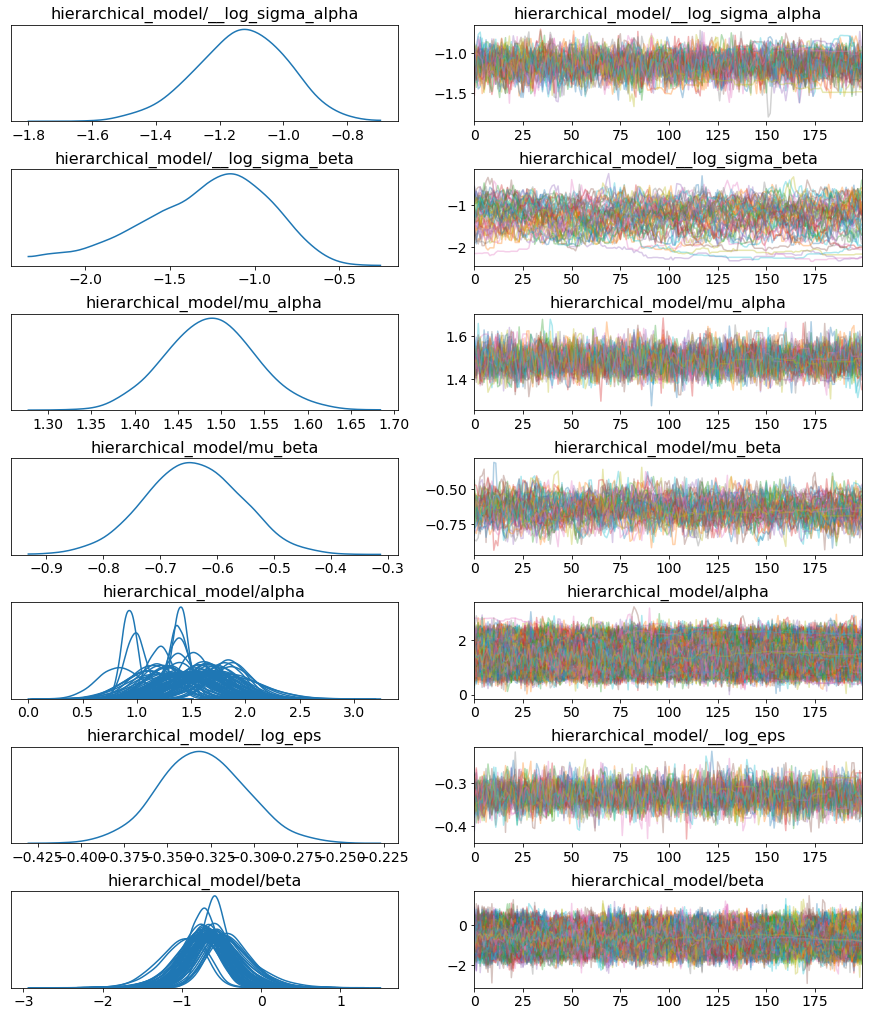

In [8]:
az.plot_trace(az_trace, compact=True, combined=True);